## Functions

In [1]:
import datetime
import copy
import os


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


plt.style.use(['seaborn-talk'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [25]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)

np.seterr(divide="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [67]:
plt.style.use('ggplot')

In [3]:
def matmul_log(A, log_b):
    res = []
    for tmp_line in A:
        if np.any(tmp_line == 0.) :
            if np.all(tmp_line == 0.) :
                res.append(logsumexp(np.log([1 / len(tmp_line) for i in range(len(tmp_line))]) + log_b))
            else:
                res.append(logsumexp(np.log(tmp_line[tmp_line != 0]) + log_b[tmp_line != 0]))
        else:
            res.append(logsumexp(np.log(tmp_line) + log_b))
    return np.array(res)


In [71]:
class MSLR():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None):
        self.n_components = n_components
        self.n_iter = n_iter
        self.covariance_type = covariance_type 
        self.tol = 0.0
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        return
    
    
    def fit_predict(self, X, Y, X_test, is_multiple_sequence = False, forecast_horizon = 1):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        n_seq = len(list_X)
        list_T = [len(i) for i in list_X]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        K = self.n_components
        self.n_features = p
        
        self.transmat_ = np.array([[1. / K for j in range(K)] for i in range(K)])

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(self.transmat_), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self.transmat_ = self._calc_transmat(list_tmp_array3d_log_epsilon)
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
        
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = self.list_last_posterior[ii] @ np.linalg.matrix_power(self.transmat_, forecast_horizon)
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_transmat(self, list_tmp_array3d_log_epsilon):
        K = self.n_components
        cur_transmat = np.zeros((K, K)) 
        for ii in range(K):
            tmp_list_log_prob = []
            for jj in range(K):
                tmp_log_prob = []
                for index_X in range(len(list_tmp_array3d_log_epsilon)):
                    tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                tmp_list_log_prob.append(logsumexp(tmp_log_prob))
            tmp_list_log_prob = np.array(tmp_list_log_prob)
            tmp_list_log_prob -= np.max(tmp_list_log_prob)
            tmp_prob = np.exp(tmp_list_log_prob)
            tmp_prob /= sum(tmp_prob)
            cur_transmat[ii, :] = tmp_prob
        return cur_transmat
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
# def _test_MSLR():
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     T = 10000
    
#     list_X, list_Y = [], []
#     list_X_test = []
#     for ii in range(5):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, 3))
#         X_test = np.random.normal(loc=1.0, scale=5.0, size=(1, 3))
#         Y, list_h_label = [], []
#         for tt in range(T):
#             if tt == 0:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = init_prob, size = 1))
#             else:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = transmat[tmp_h_label], size = 1))
#             list_h_label.append(tmp_h_label)
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_X_test.append(X_test)
        
#     mslr = MSLR(n_components=3, covariance_type="full", n_iter=10)
#     pred = mslr.fit_predict(list_X, list_Y, list_X_test, is_multiple_sequence=True)
#     print(pred)
#     print(mslr.transmat_)
#     print(mslr.startprob_)
#     for tmp_lr, tmp_cov in mslr.list_lr_cov:
#         print(tmp_lr.coef_)
#         print(tmp_lr.intercept_)
#         print(tmp_cov)

#     return


# _test_MSLR()


In [77]:
class MSLRX():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None, 
                 is_logistic_regression_CV = False, logistic_regression_C = 1e10, is_logistic_regression_standardized = False,
                is_state_coef_indep = False, is_ordinal_logit = False, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.is_logistic_regression_CV = is_logistic_regression_CV
        self.logistic_regression_C = logistic_regression_C
        self.is_state_coef_indep = is_state_coef_indep
        self.is_ordinal_logit = is_ordinal_logit    # only valid when the response is 1-dim so we could sort it
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        self.is_logistic_regression_standardized = is_logistic_regression_standardized
        if is_logistic_regression_standardized:
            self.standardizer = StandardScaler()
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    if self.is_state_coef_indep or self.is_ordinal_logit:
                        if self.is_initialized:
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            tmp_new_exog = [int(i == ii_index) for i in range(K)]
                            tmp_new_exog.extend(tmp_exog)
                            tmp_prob = self.logit_clf.predict_proba(np.array([tmp_new_exog]))[0]
                            if self.is_ordinal_logit:
                                tmp_prob = tmp_prob[self.list_sorted_index_to_original_index]
                            
                        else:
                            tmp_prob = [1 / K for i in range(K)]
                    else:
                        tmp_log_prob = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                        tmp_log_prob -= np.max(tmp_log_prob)
                        tmp_prob = np.exp(tmp_log_prob)
                        tmp_prob /= np.sum(tmp_prob)
                    tmp_trans_mat.append(tmp_prob)
                list_trans_mat.append(tmp_trans_mat)
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        if self.is_ordinal_logit:
            self.list_sorted_index = np.argsort([i[0] for i, j in self.list_mvn_mean_cov])
            self.list_sorted_index_to_original_index = [i for i, j in sorted(list(enumerate(self.list_sorted_index)), key = lambda x: x[1])]
            #print(self.list_mvn_mean_cov)
            #print([i[0] for i, j in self.list_mvn_mean_cov])
            #print(self.list_sorted_index, self.list_sorted_index_to_original_index)
        
        if self.is_state_coef_indep or self.is_ordinal_logit:
            K = self.n_components
            if self.is_ordinal_logit:
                logit_clf = mord.LogisticAT(alpha = 1 / self.logistic_regression_C, verbose = 0, max_iter = 100)
            else:
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            
            for ii in range(K):
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            jj_index = self.list_sorted_index[jj] if self.is_ordinal_logit else jj
                            
                            tmp_exog = [int(i == ii_index) for i in range(K)]
                            tmp_exog.extend(exog[tt])
                            
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(tmp_exog)
                                tmp_y_nan.append(jj_index)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(tmp_exog)
                                tmp_y.append(jj_index)
                                tmp_weight.append(tmp_weight_cell)
            
            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X.extend(tmp_X_nan)
                    tmp_y.extend(tmp_y_nan)
                    tmp_weight.extend([1 / K for i in range(len(tmp_weight_nan))])

            logit_clf.fit(np.array(tmp_X), np.array(tmp_y), np.array(tmp_weight)) 
            self.logit_clf = logit_clf
            
        else:
            K = self.n_components
            self.list_coef_, self.list_intercept_ = [], []
            for ii in range(K):
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                tmp_X, tmp_y, tmp_weight = [], [], []
                tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(exog[tt])
                                tmp_y_nan.append(jj)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(exog[tt])
                                tmp_y.append(jj)
                                tmp_weight.append(tmp_weight_cell)

                if len(tmp_y_nan) >= 1: 
                    print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                    if len(set(tmp_y)) < K:
                        tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                        tmp_weight = 1

                logit_clf.fit(tmp_X, tmp_y, tmp_weight)

                if self.n_components == 2:
                    tmp_coef = np.array([- logit_clf.coef_.flatten(), logit_clf.coef_.flatten()])
                    tmp_intercept = np.array([- logit_clf.intercept_[0], logit_clf.intercept_[0]])
                else:
                    tmp_coef = logit_clf.coef_[np.argsort(logit_clf.classes_), :]
                    tmp_intercept = logit_clf.intercept_[np.argsort(logit_clf.classes_)]
                self.list_coef_.append(np.transpose(tmp_coef))
                self.list_intercept_.append(tmp_intercept)
                
        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False, exog_additional = None):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
            list_exog_additional = [np.array(i) for i in exog_additional] if exog_additional is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            list_exog_additional = [np.array(exog_additional)] if exog_additional is not None else None
            
        if self.is_logistic_regression_standardized:
            self.standardizer.fit(np.concatenate(list_exog))
            list_exog = [self.standardizer.transform(i, copy=True) for i in list_exog]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = (p_exog, K)) for i in range(K)]
        self.list_intercept_ = [np.zeros(shape = K) for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
            
        list_transmat_additional = self._est_trans_mat(list_exog_additional) if list_exog_additional is not None else None
        
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            tmp_transmat = list_cur_list_trans_mat[ii][-1]
            if list_transmat_additional is not None:
                for tmp_transmat_additional in list_transmat_additional[ii]:
                    tmp_transmat = tmp_transmat @ tmp_transmat_additional
            self.list_log_pred_posterior.append(matmul_log(np.transpose(tmp_transmat), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
            
        if self.is_logistic_regression_standardized:
            list_exog_test = [self.standardizer.transform(i, copy=True) for i in list_exog_test]
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRX():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRX()")
    
#     np.random.seed(434)
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(10):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRX(n_components=3, covariance_type="full", n_iter=10, is_logistic_regression_standardized = True)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True,
#                             exog_additional = [exog[:1] for X in list_X],
#                             )
#     print(pred)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRX()


In [78]:
class MSLRXSoluIII():
    
    def __init__(self, n_components = 2, covariance_type="full", reg_method = "OLS", kargs_reg = None, n_iter = 10, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    tmp_prob_1 = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                    tmp_prob_1 = max(min(tmp_prob_1, 1 - 1e-5), 1e-5)
                    tmp_prob_0 = 1 - tmp_prob_1
                    tmp_trans_mat.append([tmp_prob_0, tmp_prob_1])
                list_trans_mat.append(np.array(tmp_trans_mat))
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        K = self.n_components
        self.list_coef_, self.list_intercept_ = [], []
        for ii in range(K):
            
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                T = len(array3d_log_epsilon)
                for tt in range(T):
                    for jj in range(K):
                        tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                        if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                            tmp_X_nan.append(exog[tt])
                            tmp_y_nan.append(jj)
                            tmp_weight_nan.append(tmp_weight_cell)
                        else:
                            tmp_X.append(exog[tt])
                            tmp_y.append(jj)
                            tmp_weight.append(tmp_weight_cell)

            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                    tmp_weight = 1
            
            tmp_X = sm.add_constant(tmp_X, has_constant='add', prepend=True)
            res_glm = sm.GLM(exog = tmp_X, endog = tmp_y, family=sm.families.Binomial(link = sm.families.links.identity()), freq_weights = tmp_weight).fit()
            
            tmp_intercept = res_glm.params[0]
            tmp_coef = np.array(res_glm.params[1:])
            
            self.list_coef_.append(tmp_coef) 
            self.list_intercept_.append(tmp_intercept)

        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False, exog_additional = None):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
            list_exog_additional = [np.array(i) for i in exog_additional] if exog_additional is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            list_exog_additional = [np.array(exog_additional)] if exog_additional is not None else None
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = p_exog) for i in range(K)]
        self.list_intercept_ = [1 / K for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []

        list_transmat_additional = self._est_trans_mat(list_exog_additional) if list_exog_additional is not None else None
        
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            
            tmp_transmat = list_cur_list_trans_mat[ii][-1]
            if list_transmat_additional is not None:
                for tmp_transmat_additional in list_transmat_additional[ii]:
                    tmp_transmat = tmp_transmat @ tmp_transmat_additional
            self.list_log_pred_posterior.append(matmul_log(np.transpose(tmp_transmat), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRXSoluIII():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRXSoluIII()")
    
#     np.random.seed(434)
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.1], [ 0.3, 0.7]])
#     init_prob = np.array([1 / 3, 2 / 3])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(100):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRXSoluIII(n_components=2, covariance_type="full", n_iter=10)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True,
#                             exog_additional=[exog[:1] for X in list_X])
#     print(pred)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRXSoluIII()


## Sim

### Prediction accuracy

In [31]:

def data_generator_PRSLR(
    timestamp=10000,  period_length = 100,
    p_X = 5, p_Y = 1,
    sigma = 1., 
    random_state = 434):
    
    np.random.seed(random_state)
    
    start_prob = np.array([1/2, 1/2])
    K = len(start_prob)
    list_coef_lr = [np.random.uniform(low=-1, high=1, size=(p_X, p_Y)) for i in range(K)]
    list_intercept_lr = [np.random.uniform(low=-1, high=1, size=(p_Y, )) for i in range(K)]
    
    X = np.random.normal(size = (timestamp, p_X))
    exog = np.transpose([np.sin([i / period_length * 2 * np.pi for i in range(timestamp)]), np.cos([i / period_length * 2 * np.pi for i in range(timestamp)])])
    list_coef_prs = [np.random.uniform(size = (2, K), low = 10., high = 20.) for i in range(K)]
    list_intercept_prs = [np.random.uniform(size = K) for i in range(K)]
    
    list_transmat = []
    oracle_L = []
    oracle_nohidden_L = []
    h_label_L, h_prob_L = [], []
    Y = []
    for index in range(timestamp):
        if index != 0:
            trans_mat = []
            for ii in range(K):
                tmp_log_prob = exog[index - 1] @ list_coef_prs[ii] + list_intercept_prs[ii]
                tmp_log_prob -= np.max(tmp_log_prob)
                tmp_prob = np.exp(tmp_log_prob)
                tmp_prob /= np.sum(tmp_prob)
                trans_mat.append(tmp_prob)
            trans_mat = np.array(trans_mat)
            list_transmat.append(trans_mat)
            prob_h_tmp = h_label_prev @ trans_mat
            prob_h_posterior_tmp = prob_h_posterior_tmp @ trans_mat
        else:
            prob_h_tmp = start_prob
            prob_h_posterior_tmp = start_prob
        
        h_label_tmp_vec = np.random.multinomial(1, prob_h_tmp)
        h_label_tmp = np.argmax(h_label_tmp_vec)
        
        tmp_X = X[index]
        tmp_Y = tmp_X @ list_coef_lr[h_label_tmp] + list_intercept_lr[h_label_tmp] + np.random.normal(loc = 0, scale = sigma, size = (p_Y, ))
        
        oracle_L.append(prob_h_tmp @ np.array([tmp_X @ list_coef_lr[i] + list_intercept_lr[i] for i in range(K)]))
        oracle_nohidden_L.append(prob_h_posterior_tmp @ np.array([tmp_X @ list_coef_lr[i] + list_intercept_lr[i] for i in range(K)]))
        
        Y.append(tmp_Y)
        h_label_L.append(h_label_tmp)
        h_prob_L.append(prob_h_tmp)
        
        h_label_prev = h_label_tmp_vec
        
        vec_log_emission_tmp = []
        for ii in range(K):
            tmp_log_emission = np.sum(scipy.stats.norm.logpdf(tmp_Y - (tmp_X @ list_coef_lr[ii] + list_intercept_lr[ii]), scale = sigma))
            vec_log_emission_tmp.append(tmp_log_emission)
        vec_log_emission_tmp = np.array(vec_log_emission_tmp) - logsumexp(vec_log_emission_tmp)
        prob_h_posterior_tmp *= np.exp(vec_log_emission_tmp)
        prob_h_posterior_tmp /= prob_h_posterior_tmp.sum()

    Y = np.array(Y)
    oracle_L = np.array(oracle_L)
    oracle_nohidden_L = np.array(oracle_nohidden_L)
        
    return X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L



In [39]:
def PRSAR_sim(sigma = 1., T_train = 1000, T_test = 100, period_length = 100, n_epoch = 10, is_print = False, p_X = 5, p_Y = 1):
    
    if is_print:
        print("start running PRSAR_sim")
    start_time = datetime.datetime.now()
    
    n_components = 2
    n_iter = 10
    covariance_type = "diag"
    
    list_data_generated = []
    list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr = [], [], [], []
    list_pred_oracle, list_pred_oracle_nohidden, list_true = [], [], []
    list_r2 = []
    for epoch in range(n_epoch):
        
        if is_print:
            print("\t starting epoch =", epoch, str(datetime.datetime.now() - start_time))
        
        X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L = \
            data_generator_PRSLR(timestamp = T_train + T_test, period_length = period_length, p_X = p_X, p_Y = p_Y, sigma = sigma, random_state = 434 + epoch)
        
        tmp_list_pred_mslr, tmp_list_pred_mslrx, tmp_list_pred_mslrxsolu3, tmp_list_pred_lr = [], [], [], []
        tmp_list_pred_oracle, tmp_list_pred_oracle_nohidden, tmp_list_true = [], [], []
        for tt_test in range(T_train, T_train + T_test):
            
            tmp_list_true.append(Y[tt_test])
            tmp_list_pred_oracle.append(oracle_L[tt_test])
            tmp_list_pred_oracle_nohidden.append(oracle_nohidden_L[tt_test])
            
            reg = LinearRegression()
            reg.fit(X[:tt_test], Y[:tt_test])
            tmp_pred = reg.predict([X[tt_test]])
            tmp_list_pred_lr.append(tmp_pred)
            
            mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslr.fit_predict(X[:tt_test], Y[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslr.append(tmp_pred)
            
            mslrx = MSLRX(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(X[:tt_test], Y[:tt_test], exog[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslrx.append(tmp_pred)
            
            mslrx = MSLRXSoluIII(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(X[:tt_test], Y[:tt_test], exog[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslrxsolu3.append(tmp_pred)
            
        tmp_list_true = np.array(tmp_list_true)
        tmp_list_pred_oracle = np.array(tmp_list_pred_oracle)
        tmp_list_pred_oracle_nohidden = np.array(tmp_list_pred_oracle_nohidden)
        tmp_list_pred_mslr = np.array(tmp_list_pred_mslr)
        tmp_list_pred_mslrx = np.array(tmp_list_pred_mslrx)
        tmp_list_pred_mslrxsolu3 = np.array(tmp_list_pred_mslrxsolu3)
        tmp_list_pred_lr = np.array(tmp_list_pred_lr)
            
        tmp_r2_oracle = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle.flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle_nohidden.flatten())
        tmp_r2_lr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_lr.flatten())
        tmp_r2_mslr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslr.flatten())
        tmp_r2_mslrx = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrx.flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrxsolu3.flatten())
        
        if is_print:
            print("\t r2 (oracle-nohidden) =", tmp_r2_oracle_nohidden)
            print("\t r2 (oracle) =", tmp_r2_oracle)
            print("\t r2 (LR) =", tmp_r2_lr)
            print("\t r2 (MS-LR) =", tmp_r2_mslr)
            print("\t r2 (PRS-LR) =", tmp_r2_mslrx)
            print("\t r2 (PRS-LR-SoluIII) =", tmp_r2_mslrxsolu3)
        
        list_pred_mslr.append(tmp_list_pred_mslr)
        list_pred_mslrx.append(tmp_list_pred_mslrx)
        list_pred_mslrxsolu3.append(tmp_list_pred_mslrxsolu3)
        list_pred_lr.append(tmp_list_pred_lr)
        list_pred_oracle.append(tmp_list_pred_oracle)
        list_pred_oracle_nohidden.append(tmp_list_pred_oracle_nohidden)
        list_true.append(tmp_list_true)
        
        list_data_generated.append((X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L))
        list_r2.append((tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3))
        
    if is_print:
        print("running time =", str(datetime.datetime.now() - start_time))
            
    return list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true


# list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = PRSAR_sim(T_train = 100, T_test = 10, period_length = 10, n_epoch = 5, is_print = True)


In [36]:
def _Main():
    
    start_time = datetime.datetime.now()
    
    list_sigma = [0.1, 1., 10., ]
    T_train, T_test, period_length = 500, 50, 50
    n_epoch = 50
    p_X, p_Y = 5, 1
    
    dict_setting_list_r2 = dict()
    for tmp_sigma in list_sigma:
    
        list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = \
            PRSAR_sim(sigma = tmp_sigma, T_train = T_train, T_test = T_test, period_length = period_length, n_epoch = n_epoch, is_print = False, 
                     p_X = p_X, p_Y = p_Y)
        
        tmp_r2_oracle = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle).flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle_nohidden).flatten())
        tmp_r2_lr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_lr).flatten())
        tmp_r2_mslr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslr).flatten())
        tmp_r2_mslrx = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrx).flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrxsolu3).flatten())

        tmp_setting = (tmp_sigma, p_X, p_Y)
        
        #mean_list_r2 = np.mean(list_r2, axis = 0)
        mean_list_r2 = (tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3)
        
        dict_setting_list_r2[tmp_setting] = mean_list_r2

        print("setting:", tmp_setting, str(datetime.datetime.now() - start_time))
        print("r2: oracle-nohidden = % s, oracle = % s, LR = % s, MS-LR = % s, PRS-LR = % s, PRS-LR-SoluIII = % s" % tuple(mean_list_r2))
                
    return dict_setting_list_r2
    
    
dict_setting_list_r2 = _Main()
    

setting: (0.1, 5, 1) 5:20:12.716490
r2: oracle-nohidden = 0.8299011955648922, oracle = 0.8333374456783539, LR = 0.5135765698936303, MS-LR = 0.6010945867822459, PRS-LR = 0.817038296343177, PRS-LR-SoluIII = 0.7156933077464736
setting: (1.0, 5, 1) 10:04:23.850904
r2: oracle-nohidden = 0.5460015006323604, oracle = 0.5713056747836585, LR = 0.3360914773389053, MS-LR = 0.3712774467894455, PRS-LR = 0.48218227403910074, PRS-LR-SoluIII = 0.44537051610051503
setting: (10.0, 5, 1) 14:43:42.686135
r2: oracle-nohidden = 0.01866730495608293, oracle = 0.02168970206898757, LR = 0.006394218541859509, MS-LR = 0.006637493380440951, PRS-LR = 0.0023566274786477326, PRS-LR-SoluIII = 0.002453746730597839


In [89]:
def _Main():
    
    start_time = datetime.datetime.now()
    
    list_sigma = [0.01, ]
    T_train, T_test, period_length = 500, 50, 50
    n_epoch = 50
    p_X, p_Y = 5, 1
    
    dict_setting_list_r2 = dict()
    for tmp_sigma in list_sigma:
    
        list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = \
            PRSAR_sim(sigma = tmp_sigma, T_train = T_train, T_test = T_test, period_length = period_length, n_epoch = n_epoch, is_print = False, 
                     p_X = p_X, p_Y = p_Y)
        
        tmp_r2_oracle = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle).flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle_nohidden).flatten())
        tmp_r2_lr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_lr).flatten())
        tmp_r2_mslr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslr).flatten())
        tmp_r2_mslrx = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrx).flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrxsolu3).flatten())

        tmp_setting = (tmp_sigma, p_X, p_Y)
        
        #mean_list_r2 = np.mean(list_r2, axis = 0)
        mean_list_r2 = (tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3)
        
        dict_setting_list_r2[tmp_setting] = mean_list_r2

        print("setting:", tmp_setting, str(datetime.datetime.now() - start_time))
        print("r2: oracle-nohidden = % s, oracle = % s, LR = % s, MS-LR = % s, PRS-LR = % s, PRS-LR-SoluIII = % s" % tuple(mean_list_r2))
                
    return dict_setting_list_r2
    
    
dict_setting_list_r2 = _Main()
    

setting: (0.01, 5, 1) 1:54:35.847726
r2: oracle-nohidden = 0.9879718543344215, oracle = 0.9879965997274998, LR = 0.9654653062432378, MS-LR = 0.9714379593391531, PRS-LR = 0.9875619184028618, PRS-LR-SoluIII = -0.0009238489997001054


In [90]:
with open(r"res/res_PRSAR_sim_0227.csv", "a") as fw:
    
    fw.write(",".join(["sigma_Y", "dim_X", "dim_Y", 
                       "mean_r2_oracle_nohidden", "mean_r2_oracle", "mean_r2_lr", "mean_r2_mslr", "mean_r2_mslrx", "mean_r2_mslrxsolu3", ]) + "\n")
    
    for tmp_key in dict_setting_list_r2:
        
        tmp_sigma, p_X, p_Y = tmp_key
        tmp_mean_r2_oracle_nohidden, tmp_mean_r2_oracle, tmp_mean_r2_lr, tmp_mean_r2_mslr, tmp_mean_r2_mslrx, tmp_mean_r2_mslrxsolu3 = dict_setting_list_r2[tmp_key]
        
        fw.write(",".join([str(i) for i in [tmp_sigma, p_X, p_Y, tmp_mean_r2_oracle_nohidden, tmp_mean_r2_oracle, tmp_mean_r2_lr, tmp_mean_r2_mslr, tmp_mean_r2_mslrx, tmp_mean_r2_mslrxsolu3]]) + "\n")
    

### Feature importance

In [54]:

def data_generator_PRSLR_sparse(
    timestamp=10000,  period_length = 100,
    p_X = 2, p_Y = 1,
    p_sparse_X = 1,
    sigma = 1., 
    random_state = 434):
    
    np.random.seed(random_state)
    
    start_prob = np.array([1/2, 1/2])
    K = len(start_prob)
    list_coef_lr = [np.random.uniform(low=1, high=2, size=(p_X, p_Y)) for i in range(K)]
    list_intercept_lr = [np.random.uniform(low=-1, high=1, size=(p_Y, )) for i in range(K)]
    
    for ii in range(K):
        for jj in range(p_sparse_X):
            if jj < p_X:
                list_coef_lr[ii][jj, :] = 0.
    
    X = np.random.normal(size = (timestamp, p_X))
    exog = np.transpose([np.sin([i / period_length * 2 * np.pi for i in range(timestamp)]), np.cos([i / period_length * 2 * np.pi for i in range(timestamp)])])
    list_coef_prs = [np.random.uniform(size = (2, K), low = 10., high = 20.) for i in range(K)]
    list_intercept_prs = [np.random.uniform(size = K) for i in range(K)]
    
    list_transmat = []
    oracle_L = []
    oracle_nohidden_L = []
    h_label_L, h_prob_L = [], []
    Y = []
    for index in range(timestamp):
        if index != 0:
            trans_mat = []
            for ii in range(K):
                tmp_log_prob = exog[index - 1] @ list_coef_prs[ii] + list_intercept_prs[ii]
                tmp_log_prob -= np.max(tmp_log_prob)
                tmp_prob = np.exp(tmp_log_prob)
                tmp_prob /= np.sum(tmp_prob)
                trans_mat.append(tmp_prob)
            trans_mat = np.array(trans_mat)
            list_transmat.append(trans_mat)
            prob_h_tmp = h_label_prev @ trans_mat
            prob_h_posterior_tmp = prob_h_posterior_tmp @ trans_mat
        else:
            prob_h_tmp = start_prob
            prob_h_posterior_tmp = start_prob
        
        h_label_tmp_vec = np.random.multinomial(1, prob_h_tmp)
        h_label_tmp = np.argmax(h_label_tmp_vec)
        
        tmp_X = X[index]
        tmp_Y = tmp_X @ list_coef_lr[h_label_tmp] + list_intercept_lr[h_label_tmp] + np.random.normal(loc = 0, scale = sigma, size = (p_Y, ))
        
        oracle_L.append(prob_h_tmp @ np.array([tmp_X @ list_coef_lr[i] + list_intercept_lr[i] for i in range(K)]))
        oracle_nohidden_L.append(prob_h_posterior_tmp @ np.array([tmp_X @ list_coef_lr[i] + list_intercept_lr[i] for i in range(K)]))
        
        Y.append(tmp_Y)
        h_label_L.append(h_label_tmp)
        h_prob_L.append(prob_h_tmp)
        
        h_label_prev = h_label_tmp_vec
        
        vec_log_emission_tmp = []
        for ii in range(K):
            tmp_log_emission = np.sum(scipy.stats.norm.logpdf(tmp_Y - (tmp_X @ list_coef_lr[ii] + list_intercept_lr[ii]), scale = sigma))
            vec_log_emission_tmp.append(tmp_log_emission)
        vec_log_emission_tmp = np.array(vec_log_emission_tmp) - logsumexp(vec_log_emission_tmp)
        prob_h_posterior_tmp *= np.exp(vec_log_emission_tmp)
        prob_h_posterior_tmp /= prob_h_posterior_tmp.sum()

    Y = np.array(Y)
    oracle_L = np.array(oracle_L)
    oracle_nohidden_L = np.array(oracle_nohidden_L)
        
    return X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L



#### out-of-sample

In [86]:
def PRSAR_sim_sparse(sigma = 1., T_train = 1000, T_test = 100, period_length = 100, n_epoch = 10, is_print = False, p_X = 2, p_sparse_X = 1, p_Y = 1,
              features_used = None, is_mslrxsolu3 = False):
    
    if is_print:
        print("start running PRSAR_sim")
    start_time = datetime.datetime.now()
    
    n_components = 2
    n_iter = 10
    covariance_type = "diag"
    
    if features_used is None:
        list_index_feature_used = list(range(p_X))
    else:
        list_index_feature_used = list(features_used)
    
    list_data_generated = []
    list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr = [], [], [], []
    list_pred_oracle, list_pred_oracle_nohidden, list_true = [], [], []
    list_r2 = []
    for epoch in range(n_epoch):
        
        if is_print:
            print("\t starting epoch =", epoch, str(datetime.datetime.now() - start_time))
        
        X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L = \
            data_generator_PRSLR_sparse(timestamp = T_train + T_test, period_length = period_length, p_X = p_X, p_sparse_X = p_sparse_X, p_Y = p_Y, sigma = sigma, random_state = 434 + epoch)
        
        X = X[:, list_index_feature_used]
        
        tmp_list_pred_mslr, tmp_list_pred_mslrx, tmp_list_pred_mslrxsolu3, tmp_list_pred_lr = [], [], [], []
        tmp_list_pred_oracle, tmp_list_pred_oracle_nohidden, tmp_list_true = [], [], []
        for tt_test in range(T_train, T_train + T_test):
            
            tmp_list_true.append(Y[tt_test])
            tmp_list_pred_oracle.append(oracle_L[tt_test])
            tmp_list_pred_oracle_nohidden.append(oracle_nohidden_L[tt_test])
            
            reg = LinearRegression()
            reg.fit(X[:tt_test], Y[:tt_test])
            tmp_pred = reg.predict([X[tt_test]])
            tmp_list_pred_lr.append(tmp_pred)
            
            mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslr.fit_predict(X[:tt_test], Y[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslr.append(tmp_pred)
            
            mslrx = MSLRX(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(X[:tt_test], Y[:tt_test], exog[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslrx.append(tmp_pred)
            
            if is_mslrxsolu3:
                mslrx = MSLRXSoluIII(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
                tmp_pred = mslrx.fit_predict(X[:tt_test], Y[:tt_test], exog[:tt_test], X[tt_test], is_multiple_sequence = False)
                tmp_list_pred_mslrxsolu3.append(tmp_pred)
            else:
                tmp_list_pred_mslrxsolu3.append(np.zeros(np.shape(tmp_pred)))
            
        tmp_list_true = np.array(tmp_list_true)
        tmp_list_pred_oracle = np.array(tmp_list_pred_oracle)
        tmp_list_pred_oracle_nohidden = np.array(tmp_list_pred_oracle_nohidden)
        tmp_list_pred_mslr = np.array(tmp_list_pred_mslr)
        tmp_list_pred_mslrx = np.array(tmp_list_pred_mslrx)
        tmp_list_pred_mslrxsolu3 = np.array(tmp_list_pred_mslrxsolu3)
        tmp_list_pred_lr = np.array(tmp_list_pred_lr)
            
        tmp_r2_oracle = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle.flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle_nohidden.flatten())
        tmp_r2_lr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_lr.flatten())
        tmp_r2_mslr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslr.flatten())
        tmp_r2_mslrx = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrx.flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrxsolu3.flatten())
        
        if is_print:
            print("\t r2 (oracle-nohidden) =", tmp_r2_oracle_nohidden)
            print("\t r2 (oracle) =", tmp_r2_oracle)
            print("\t r2 (LR) =", tmp_r2_lr)
            print("\t r2 (MS-LR) =", tmp_r2_mslr)
            print("\t r2 (PRS-LR) =", tmp_r2_mslrx)
            print("\t r2 (PRS-LR-SoluIII) =", tmp_r2_mslrxsolu3)
        
        list_pred_mslr.append(tmp_list_pred_mslr)
        list_pred_mslrx.append(tmp_list_pred_mslrx)
        list_pred_mslrxsolu3.append(tmp_list_pred_mslrxsolu3)
        list_pred_lr.append(tmp_list_pred_lr)
        list_pred_oracle.append(tmp_list_pred_oracle)
        list_pred_oracle_nohidden.append(tmp_list_pred_oracle_nohidden)
        list_true.append(tmp_list_true)
        
        list_data_generated.append((X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L))
        list_r2.append((tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3))
        
    if is_print:
        print("running time =", str(datetime.datetime.now() - start_time))
            
    return list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true


# list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = PRSAR_sim(T_train = 100, T_test = 10, period_length = 10, n_epoch = 5, is_print = True)


In [114]:
def _Main():
    
    start_time = datetime.datetime.now()
    
    list_sigma = [0.1, 1., ]
    T_train, T_test, period_length = 500, 50, 50
    n_epoch = 50
    p_X, p_Y = 5, 1
    p_sparse_X = 2
    
    dict_setting_list_r2 = dict()
    for tmp_sigma in list_sigma:
            
        for feature_removed in [None, 0, 1, 2, 3, 4]:
            
            if feature_removed is None:
                list_feature_used = list(range(p_X)) 
            else:
                list_feature_used = [i for i in range(p_X) if i != feature_removed]
            
            list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = \
                PRSAR_sim_sparse(sigma = tmp_sigma, T_train = T_train, T_test = T_test, period_length = period_length, n_epoch = n_epoch, is_print = False, 
                         p_X = p_X, p_Y = p_Y, p_sparse_X = p_sparse_X, features_used = list_feature_used, is_mslrxsolu3=True)

            tmp_r2_oracle = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle).flatten())
            tmp_r2_oracle_nohidden = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle_nohidden).flatten())
            tmp_r2_lr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_lr).flatten())
            tmp_r2_mslr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslr).flatten())
            tmp_r2_mslrx = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrx).flatten())
            tmp_r2_mslrxsolu3 = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrxsolu3).flatten())

            tmp_setting = (tmp_sigma, p_X, p_Y, feature_removed)

            #mean_list_r2 = np.mean(list_r2, axis = 0)
            mean_list_r2 = (tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3)

            dict_setting_list_r2[tmp_setting] = mean_list_r2

            print("setting:", tmp_setting, str(datetime.datetime.now() - start_time))
            print("r2: oracle-nohidden = % s, oracle = % s, LR = % s, MS-LR = % s, PRS-LR = % s, PRS-LR-SoluIII = % s" % tuple(mean_list_r2))
                
    return dict_setting_list_r2
    
    
dict_setting_list_r2 = _Main()
    

setting: (10.0, 5, 1, None) 3:33:44.358990
r2: oracle-nohidden = 0.0812954312267149, oracle = 0.08238310316030484, LR = 0.07671014511148277, MS-LR = 0.07680733076152835, PRS-LR = 0.07289097261356303, PRS-LR-SoluIII = 0.07295920542918866



KeyboardInterrupt



In [ ]:
with open(r"res/res_PRSAR_sim_feature_0305.csv", "a") as fw:
    
    fw.write(",".join(["sigma_Y", "dim_X", "dim_Y", "feature_removed",
                       "mean_r2_oracle_nohidden", "mean_r2_oracle", "mean_r2_lr", "mean_r2_mslr", "mean_r2_mslrx", "mean_r2_mslrxsolu3", ]) + "\n")
    
    for tmp_key in dict_setting_list_r2:
        
        tmp_sigma, p_X, p_Y, feature_removed = tmp_key
        tmp_mean_r2_oracle_nohidden, tmp_mean_r2_oracle, tmp_mean_r2_lr, tmp_mean_r2_mslr, tmp_mean_r2_mslrx, tmp_mean_r2_mslrxsolu3 = dict_setting_list_r2[tmp_key]
        
        fw.write(",".join([str(i) for i in [tmp_sigma, p_X, p_Y, feature_removed, tmp_mean_r2_oracle_nohidden, tmp_mean_r2_oracle, tmp_mean_r2_lr, tmp_mean_r2_mslr, tmp_mean_r2_mslrx, tmp_mean_r2_mslrxsolu3]]) + "\n")
    

#### in-sample

In [91]:
def prslr_feature_selection(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = "mslrx"):
    
    S = n_components
    
    if is_multiple_sequence:
        p_X, p_Y = len(X[0][0]), len(Y[0][0])
        X = [np.array(i) for i in X]
        Y = [np.array(i) for i in Y]
    else:
        p_X, p_Y = len(X[0]), len(Y[0])
        X, Y = np.array(X), np.array(Y)
    
    if method.lower() == "mslrx":
        method_cls = MSLRX
    elif method.lower() == "mslrxsolu3":
        method_cls = MSLRXSoluIII
    elif method.lower() == "mslr":
        method_cls = MSLR
    else:
        print("Error: no method = % s" % method)
        return
        
    delta_df = p_Y * S
    
    mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    if method.lower() == "mslr":
        mslrx.fit(X, Y, is_multiple_sequence = is_multiple_sequence)
    else:
        mslrx.fit(X, Y, exog, is_multiple_sequence = is_multiple_sequence)
    
    
    loglik_full = mslrx.list_loglik_[-1]
    
    list_loglik_reduced, list_pvalues = [], []
    for ii in range(p_X):
        list_used_features = [i for i in range(p_X) if i != ii]
        mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
        
        if is_multiple_sequence:
            X_reduced = [i[:, list_used_features] for i in X]
        else:
            X_reduced = X[:, list_used_features]
            
        if method.lower() == "mslr":
            mslrx.fit(X_reduced, Y, is_multiple_sequence = is_multiple_sequence)
        else:
            mslrx.fit(X_reduced, Y, exog, is_multiple_sequence = is_multiple_sequence)
            
        tmp_loglik_reduced = mslrx.list_loglik_[-1]
        list_loglik_reduced.append(tmp_loglik_reduced)
        
        tmp_pvalue = scipy.stats.chi2.sf(-2 * (tmp_loglik_reduced - loglik_full), delta_df)
        list_pvalues.append(tmp_pvalue)
        
    return list_loglik_reduced, list_pvalues, loglik_full
    

In [101]:
def prslr_testing_prs(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = "mslrx"):
    
    S = n_components
    
    if method.lower() == "mslrx":
        method_cls = MSLRX
    elif method.lower() == "mslrxsolu3":
        method_cls = MSLRXSoluIII
    else:
        print("Error: no method = % s" % method)
        return
        
    delta_df = 2 * S * (S - 1)
    
    mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    mslrx.fit(X, Y, exog, is_multiple_sequence = is_multiple_sequence)
    loglik_prslr = mslrx.list_loglik_[-1]
    
    mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    mslr.fit(X, Y, is_multiple_sequence = is_multiple_sequence)
    loglik_rslr = mslr.list_loglik_[-1]
    
    pvalue = scipy.stats.chi2.sf(-2 * (loglik_rslr - loglik_prslr), delta_df)
    
    return pvalue, loglik_prslr, loglik_rslr
    

In [110]:
def _Main():
    
    start_time = datetime.datetime.now()
    
    sigma = 1.  
     
    T, period_length = 1000, 50
    p_X, p_Y = 5, 1
    p_sparse_X = 2
    n_components = 2
    covariance_type = "diag"
    n_iter = 10
    
    dict_col_val = dict()
    
    for method_mslr in ["mslr", "mslrx", "mslrxsolu3"]:
    
        X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L = \
            data_generator_PRSLR_sparse(timestamp = T, period_length = period_length, p_X = p_X, p_sparse_X = p_sparse_X,
                                        p_Y = p_Y, sigma = sigma, random_state = 434)

        list_loglik_reduced, list_pvalues, loglik_full = prslr_feature_selection(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method=method_mslr)

        if method_mslr != "mslr":
            pvalue_prs, loglik_prslr, loglik_rslr = prslr_testing_prs(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = method_mslr)
        else:
            pvalue_prs = 1.0
        
        list_pvalues.append(pvalue_prs)
        
        print(pvalue_prs)
        
        dict_col_val[method_mslr] = list_pvalues
        
    return pd.DataFrame(dict_col_val)
    
    
tmp_res_df = _Main()
    

1.0
4.019462175515429e-83
1.5889592198527822e-80


In [111]:
tmp_res_df

,mslr,mslrx,mslrxsolu3
0,0.273552,1.992755e-01,1.983308e-01
1,0.183669,7.373157e-02,4.105242e-266
2,0.000000,0.000000e+00,0.000000e+00
3,0.000000,0.000000e+00,0.000000e+00
4,0.000000,0.000000e+00,0.000000e+00
5,1.000000,4.019462e-83,1.588959e-80


### Prediction accuracy (AR)

In [94]:

def data_generator_PRSAR(
    timestamp=10000,  period_length = 100,
    p_X = 5,
    sigma = 1., 
    random_state = 434):
    
    np.random.seed(random_state)
    
    p_Y = p_X
    K = 2
    start_prob = np.array([1/K] * K)
    list_intercept_lr = [np.zeros(shape=p_Y) for i in range(K)]
    list_coef_lr = []
    for ii in range(K):
        # tmp_beta = np.random.uniform(low=-1, high=1, size=(p_X, p_Y))
        # while np.abs(np.linalg.eigvals(tmp_beta)).max() >=1.:
        #     tmp_beta = np.random.uniform(low=-1, high=1, size=(p_X, p_Y))
        tmp_beta = np.ones(shape=(p_X, p_Y)) * 0.8 * ((-1) ** ii)
        list_coef_lr.append(tmp_beta)
        
    exog = np.transpose([np.sin([i / period_length * 2 * np.pi for i in range(timestamp)]), np.cos([i / period_length * 2 * np.pi for i in range(timestamp)])])
    # list_coef_prs = [np.random.uniform(size = (2, K), low = 10., high = 20.) for i in range(K)]
    # list_intercept_prs = [np.random.uniform(size = K) for i in range(K)]
    list_coef_prs = [np.array([[11., 20.], [18., 12.]]),
                     np.array([[14., 16.  ], [15., 16.]])]
    list_intercept_prs = [np.array([0.1, 0.5]), np.array([0.5, 0.1])]
    print(list_coef_prs)
    print(list_intercept_prs)
    
    list_transmat = []
    oracle_L = []
    oracle_nohidden_L = []
    h_label_L, h_prob_L = [], []
    Y = []
    X = []
    for index in range(timestamp):
        if index != 0:
            trans_mat = []
            for ii in range(K):
                tmp_log_prob = exog[index - 1] @ list_coef_prs[ii] + list_intercept_prs[ii]
                tmp_log_prob -= np.max(tmp_log_prob)
                tmp_prob = np.exp(tmp_log_prob)
                tmp_prob /= np.sum(tmp_prob)
                trans_mat.append(tmp_prob)
            trans_mat = np.array(trans_mat)
            list_transmat.append(trans_mat)
            prob_h_tmp = h_label_prev @ trans_mat
            prob_h_posterior_tmp = prob_h_posterior_tmp @ trans_mat
        else:
            prob_h_tmp = start_prob
            prob_h_posterior_tmp = start_prob
        
        h_label_tmp_vec = np.random.multinomial(1, prob_h_tmp)
        h_label_tmp = np.argmax(h_label_tmp_vec)
        
        if index == 0:
            tmp_X = np.random.normal(size = p_X) * sigma
        else:
            tmp_X = Y[-1]
            
        tmp_Y = tmp_X @ list_coef_lr[h_label_tmp] + list_intercept_lr[h_label_tmp] + np.random.normal(loc = 0, scale = sigma, size = (p_Y, ))
        
        oracle_L.append(prob_h_tmp @ np.array([tmp_X @ list_coef_lr[i] + list_intercept_lr[i] for i in range(K)]))
        oracle_nohidden_L.append(prob_h_posterior_tmp @ np.array([tmp_X @ list_coef_lr[i] + list_intercept_lr[i] for i in range(K)]))
        
        X.append(tmp_X)
        Y.append(tmp_Y)
        h_label_L.append(h_label_tmp)
        h_prob_L.append(prob_h_tmp)
        
        h_label_prev = h_label_tmp_vec
        
        vec_log_emission_tmp = []
        for ii in range(K):
            tmp_log_emission = np.sum(scipy.stats.norm.logpdf(tmp_Y - (tmp_X @ list_coef_lr[ii] + list_intercept_lr[ii]), scale = sigma))
            vec_log_emission_tmp.append(tmp_log_emission)
        vec_log_emission_tmp = np.array(vec_log_emission_tmp) - logsumexp(vec_log_emission_tmp)
        prob_h_posterior_tmp *= np.exp(vec_log_emission_tmp)
        prob_h_posterior_tmp /= prob_h_posterior_tmp.sum()

    Y = np.array(Y)
    oracle_L = np.array(oracle_L)
    oracle_nohidden_L = np.array(oracle_nohidden_L)
    
    plt.plot(Y)
    plt.show()
        
    return X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L


In [95]:
def PRSAR_sim(sigma = 1., T_train = 1000, T_test = 100, period_length = 100, n_epoch = 10, is_print = False, p_X = 5):
    
    if is_print:
        print("start running PRSAR_sim")
    start_time = datetime.datetime.now()
    
    n_components = 2
    n_iter = 10
    covariance_type = "diag"
    
    list_data_generated = []
    list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr = [], [], [], []
    list_pred_oracle, list_pred_oracle_nohidden, list_true = [], [], []
    list_r2 = []
    for epoch in range(n_epoch):
        
        if is_print:
            print("\t starting epoch =", epoch, str(datetime.datetime.now() - start_time))
        
        X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L = \
            data_generator_PRSAR(timestamp = T_train + T_test, period_length = period_length, p_X = p_X, sigma = sigma, random_state = 434 + epoch)
        
        tmp_list_pred_mslr, tmp_list_pred_mslrx, tmp_list_pred_mslrxsolu3, tmp_list_pred_lr = [], [], [], []
        tmp_list_pred_oracle, tmp_list_pred_oracle_nohidden, tmp_list_true = [], [], []
        for tt_test in range(T_train, T_train + T_test):
            
            tmp_list_true.append(Y[tt_test])
            tmp_list_pred_oracle.append(oracle_L[tt_test])
            tmp_list_pred_oracle_nohidden.append(oracle_nohidden_L[tt_test])
            
            reg = LinearRegression()
            reg.fit(X[:tt_test], Y[:tt_test])
            tmp_pred = reg.predict([X[tt_test]])
            tmp_list_pred_lr.append(tmp_pred)
            
            mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslr.fit_predict(X[:tt_test], Y[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslr.append(tmp_pred)
            
            mslrx = MSLRX(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(X[:tt_test], Y[:tt_test], exog[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslrx.append(tmp_pred)
            
            mslrx = MSLRXSoluIII(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(X[:tt_test], Y[:tt_test], exog[:tt_test], X[tt_test], is_multiple_sequence = False)
            tmp_list_pred_mslrxsolu3.append(tmp_pred)
            
        tmp_list_true = np.array(tmp_list_true)
        tmp_list_pred_oracle = np.array(tmp_list_pred_oracle)
        tmp_list_pred_oracle_nohidden = np.array(tmp_list_pred_oracle_nohidden)
        tmp_list_pred_mslr = np.array(tmp_list_pred_mslr)
        tmp_list_pred_mslrx = np.array(tmp_list_pred_mslrx)
        tmp_list_pred_mslrxsolu3 = np.array(tmp_list_pred_mslrxsolu3)
        tmp_list_pred_lr = np.array(tmp_list_pred_lr)
            
        tmp_r2_oracle = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle.flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle_nohidden.flatten())
        tmp_r2_lr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_lr.flatten())
        tmp_r2_mslr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslr.flatten())
        tmp_r2_mslrx = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrx.flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrxsolu3.flatten())
        
        if is_print:
            print("\t r2 (oracle-nohidden) =", tmp_r2_oracle_nohidden)
            print("\t r2 (oracle) =", tmp_r2_oracle)
            print("\t r2 (LR) =", tmp_r2_lr)
            print("\t r2 (MS-LR) =", tmp_r2_mslr)
            print("\t r2 (PRS-LR) =", tmp_r2_mslrx)
            print("\t r2 (PRS-LR-SoluIII) =", tmp_r2_mslrxsolu3)
        
        list_pred_mslr.append(tmp_list_pred_mslr)
        list_pred_mslrx.append(tmp_list_pred_mslrx)
        list_pred_mslrxsolu3.append(tmp_list_pred_mslrxsolu3)
        list_pred_lr.append(tmp_list_pred_lr)
        list_pred_oracle.append(tmp_list_pred_oracle)
        list_pred_oracle_nohidden.append(tmp_list_pred_oracle_nohidden)
        list_true.append(tmp_list_true)
        
        list_data_generated.append((X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L))
        list_r2.append((tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3))
        
    if is_print:
        print("running time =", str(datetime.datetime.now() - start_time))
            
    return list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true


# list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = PRSAR_sim(T_train = 100, T_test = 10, period_length = 10, n_epoch = 5, is_print = True)


In [102]:
def PRSAR_sim_horizon(sigma = 1., T_train = 1000, T_test = 100, period_length = 100, n_epoch = 10, forecast_horizon = 1, is_print = False, p_X = 5):
    
    if is_print:
        print("start running PRSAR_sim")
    start_time = datetime.datetime.now()
    
    n_components = 2
    n_iter = 5
    covariance_type = "diag"
    
    list_data_generated = []
    list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr = [], [], [], []
    list_pred_oracle, list_pred_oracle_nohidden, list_true = [], [], []
    list_pred_naive = []
    list_r2 = []
    for epoch in range(n_epoch):
        
        if is_print:
            print("\t starting epoch =", epoch, str(datetime.datetime.now() - start_time))
        
        X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L = \
            data_generator_PRSAR(timestamp = T_train + T_test, period_length = period_length, p_X = p_X, sigma = sigma, random_state = 434 + epoch)
        
        tmp_list_pred_mslr, tmp_list_pred_mslrx, tmp_list_pred_mslrxsolu3, tmp_list_pred_lr = [], [], [], []
        tmp_list_pred_oracle, tmp_list_pred_oracle_nohidden, tmp_list_true = [], [], []
        tmp_list_pred_naive = []
        for tt_test in range(T_train, T_train + T_test):
            
            tmp_list_true.append(Y[tt_test])
            tmp_list_pred_oracle.append(oracle_L[tt_test])
            tmp_list_pred_oracle_nohidden.append(oracle_nohidden_L[tt_test])
            
            tmp_list_pred_naive.append(X[tt_test - forecast_horizon])
            
            reg = LinearRegression()
            reg.fit(X[:(tt_test - forecast_horizon + 1)], Y[:(tt_test - forecast_horizon + 1)])
            tmp_pred = reg.predict([X[tt_test]])
            tmp_list_pred_lr.append(tmp_pred)
            
            mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslr.fit_predict(X[:(tt_test - forecast_horizon + 1)], Y[:(tt_test - forecast_horizon + 1)], X[tt_test], is_multiple_sequence = False, forecast_horizon = forecast_horizon)
            tmp_list_pred_mslr.append(tmp_pred)
            
            tmp_X = copy.deepcopy(X[:(tt_test-forecast_horizon+1)])
            tmp_Y = copy.deepcopy(Y[:(tt_test-forecast_horizon+1)])
            tmp_exog = copy.deepcopy(exog[:(tt_test-forecast_horizon+1)])
            tmp_X_test = copy.deepcopy(X[tt_test])
            if forecast_horizon != 1:
                tmp_exog_additional = copy.deepcopy(exog[(tt_test-forecast_horizon+1):tt_test])
            else:
                tmp_exog_additional = None
            
            mslrx = MSLRX(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(tmp_X, tmp_Y, tmp_exog, tmp_X_test, is_multiple_sequence = False, exog_additional=tmp_exog_additional)
            tmp_list_pred_mslrx.append(tmp_pred)
            
            mslrx = MSLRXSoluIII(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
            tmp_pred = mslrx.fit_predict(tmp_X,tmp_Y, tmp_exog, tmp_X_test, is_multiple_sequence = False, exog_additional=tmp_exog_additional)
            tmp_list_pred_mslrxsolu3.append(tmp_pred)
            
        tmp_list_true = np.array(tmp_list_true)
        tmp_list_pred_oracle = np.array(tmp_list_pred_oracle)
        tmp_list_pred_oracle_nohidden = np.array(tmp_list_pred_oracle_nohidden)
        tmp_list_pred_mslr = np.array(tmp_list_pred_mslr)
        tmp_list_pred_mslrx = np.array(tmp_list_pred_mslrx)
        tmp_list_pred_mslrxsolu3 = np.array(tmp_list_pred_mslrxsolu3)
        tmp_list_pred_lr = np.array(tmp_list_pred_lr)
        tmp_list_pred_naive = np.array(tmp_list_pred_naive)
            
        tmp_r2_oracle = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle.flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_oracle_nohidden.flatten())
        tmp_r2_lr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_lr.flatten())
        tmp_r2_mslr = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslr.flatten())
        tmp_r2_mslrx = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrx.flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_mslrxsolu3.flatten())
        tmp_r2_naive = r2_score(y_true=tmp_list_true.flatten(), y_pred = tmp_list_pred_naive.flatten())
        
        if is_print:
            print("\t r2 (oracle-nohidden) =", tmp_r2_oracle_nohidden)
            print("\t r2 (oracle) =", tmp_r2_oracle)
            print("\t r2 (naive) =", tmp_r2_naive)
            print("\t r2 (LR) =", tmp_r2_lr)
            print("\t r2 (MS-LR) =", tmp_r2_mslr)
            print("\t r2 (PRS-LR) =", tmp_r2_mslrx)
            print("\t r2 (PRS-LR-SoluIII) =", tmp_r2_mslrxsolu3)
        
        list_pred_mslr.append(tmp_list_pred_mslr)
        list_pred_mslrx.append(tmp_list_pred_mslrx)
        list_pred_mslrxsolu3.append(tmp_list_pred_mslrxsolu3)
        list_pred_lr.append(tmp_list_pred_lr)
        list_pred_oracle.append(tmp_list_pred_oracle)
        list_pred_oracle_nohidden.append(tmp_list_pred_oracle_nohidden)
        list_true.append(tmp_list_true)
        list_pred_naive.append(tmp_list_pred_naive)
        
        list_data_generated.append((X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L))
        list_r2.append((tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3))
        
    if is_print:
        print("running time =", str(datetime.datetime.now() - start_time))
            
    return list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true


# list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = PRSAR_sim(T_train = 100, T_test = 10, period_length = 10, n_epoch = 5, is_print = True)


start running PRSAR_sim
	 starting epoch = 0 0:00:00
[array([[11., 20.],
       [18., 12.]]), array([[14., 16.],
       [15., 16.]])]
[array([0.1, 0.5]), array([0.5, 0.1])]


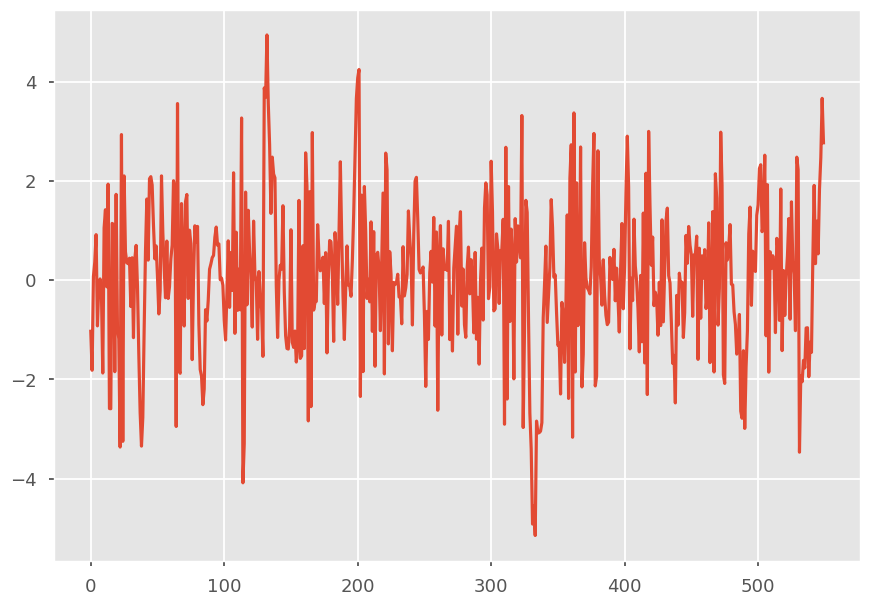

	 r2 (oracle-nohidden) = 0.532218198654727
	 r2 (oracle) = 0.5363626070635711
	 r2 (naive) = -0.1370403449477149
	 r2 (LR) = 0.0704831867697232
	 r2 (MS-LR) = 0.06626236167886546
	 r2 (PRS-LR) = 0.19504313509614635
	 r2 (PRS-LR-SoluIII) = 0.19776587433183934
running time = 0:02:29.898713
setting: (1.0, 1, 1) 0:02:29.900712
r2: oracle-nohidden = 0.532218198654727, oracle = 0.5363626070635711, LR = 0.0704831867697232, MS-LR = 0.06626236167886546, PRS-LR = 0.19504313509614635, PRS-LR-SoluIII = 0.19776587433183934
start running PRSAR_sim
	 starting epoch = 0 0:00:00
[array([[11., 20.],
       [18., 12.]]), array([[14., 16.],
       [15., 16.]])]
[array([0.1, 0.5]), array([0.5, 0.1])]


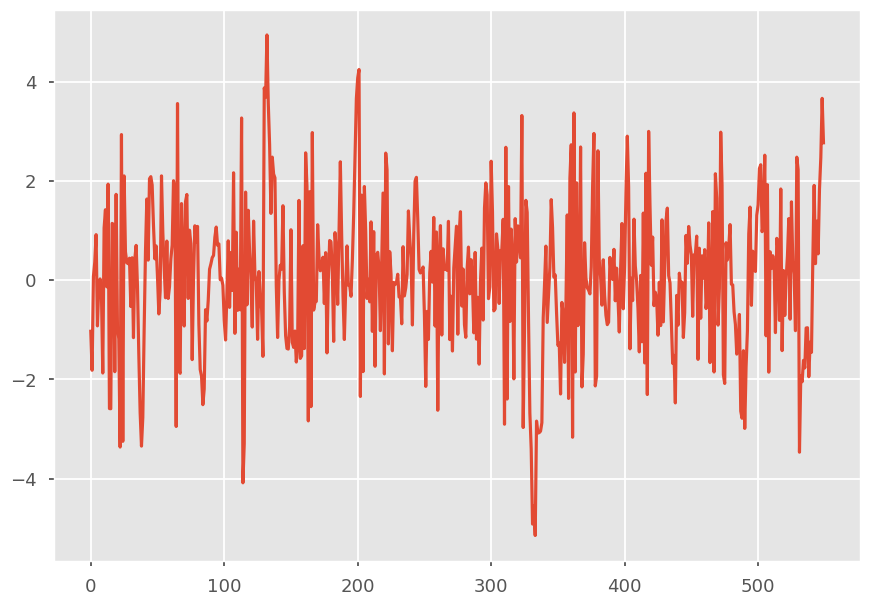

	 r2 (oracle-nohidden) = 0.532218198654727
	 r2 (oracle) = 0.5363626070635711
	 r2 (naive) = -0.416780705934753
	 r2 (LR) = 0.06571895784827209
	 r2 (MS-LR) = 0.06040979262640411
	 r2 (PRS-LR) = 0.11165624192167267
	 r2 (PRS-LR-SoluIII) = 0.11748548391178448
running time = 0:02:25.245786
setting: (1.0, 1, 3) 0:04:55.148499
r2: oracle-nohidden = 0.532218198654727, oracle = 0.5363626070635711, LR = 0.06571895784827209, MS-LR = 0.06040979262640411, PRS-LR = 0.11165624192167267, PRS-LR-SoluIII = 0.11748548391178448
start running PRSAR_sim
	 starting epoch = 0 0:00:00
[array([[11., 20.],
       [18., 12.]]), array([[14., 16.],
       [15., 16.]])]
[array([0.1, 0.5]), array([0.5, 0.1])]


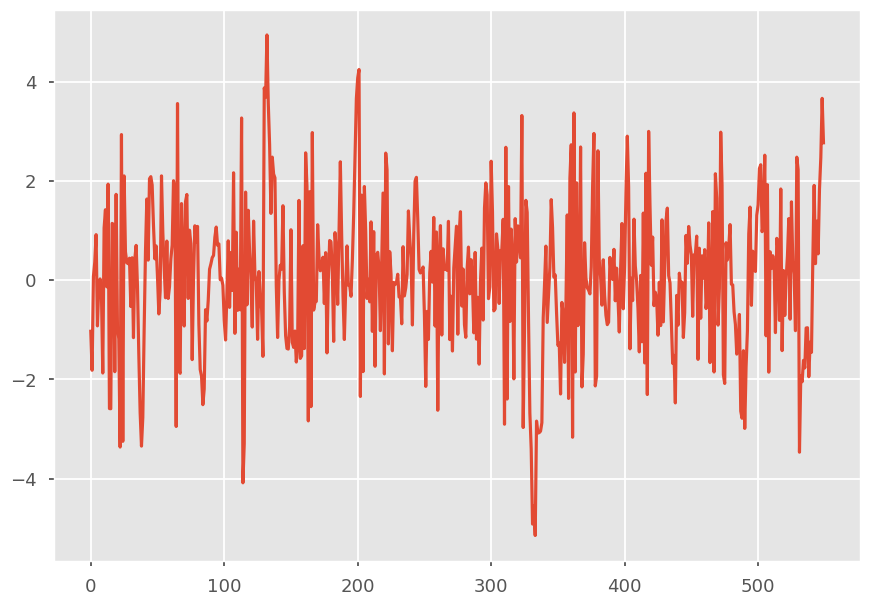

	 r2 (oracle-nohidden) = 0.532218198654727
	 r2 (oracle) = 0.5363626070635711
	 r2 (naive) = -0.9943400263660396
	 r2 (LR) = 0.06392485781647606
	 r2 (MS-LR) = 0.05923839757120086
	 r2 (PRS-LR) = 0.10574857535357673
	 r2 (PRS-LR-SoluIII) = 0.11219586574317919
running time = 0:02:34.727212
setting: (1.0, 1, 7) 0:07:29.877761
r2: oracle-nohidden = 0.532218198654727, oracle = 0.5363626070635711, LR = 0.06392485781647606, MS-LR = 0.05923839757120086, PRS-LR = 0.10574857535357673, PRS-LR-SoluIII = 0.11219586574317919


In [103]:
def _Main():
    
    start_time = datetime.datetime.now()
    
    list_forecast_horizon = [1, 3, 7]
    
    sigma = 1.
    T_train, T_test, period_length = 500, 50, 50
    n_epoch = 1
    p_X = 1
    
    dict_setting_list_r2 = dict()
    dict_setting_list_data = dict()
    for tmp_forecast_horizon in list_forecast_horizon:
    
        list_data_generated, list_r2, list_pred_mslr, list_pred_mslrx, list_pred_mslrxsolu3, list_pred_lr, list_pred_oracle, list_pred_oracle_nohidden, list_true = \
            PRSAR_sim_horizon(forecast_horizon = tmp_forecast_horizon, sigma = sigma, T_train = T_train, T_test = T_test, period_length = period_length, n_epoch = n_epoch, is_print = True, p_X = p_X)
        
        tmp_r2_oracle = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle).flatten())
        tmp_r2_oracle_nohidden = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_oracle_nohidden).flatten())
        tmp_r2_lr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_lr).flatten())
        tmp_r2_mslr = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslr).flatten())
        tmp_r2_mslrx = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrx).flatten())
        tmp_r2_mslrxsolu3 = r2_score(y_true=np.array(list_true).flatten(), y_pred = np.array(list_pred_mslrxsolu3).flatten())

        tmp_setting = (sigma, p_X, tmp_forecast_horizon)
        
        #mean_list_r2 = np.mean(list_r2, axis = 0)
        mean_list_r2 = (tmp_r2_oracle_nohidden, tmp_r2_oracle, tmp_r2_lr, tmp_r2_mslr, tmp_r2_mslrx, tmp_r2_mslrxsolu3)
        
        dict_setting_list_r2[tmp_setting] = mean_list_r2
        dict_setting_list_data[tmp_setting] = list_data_generated

        print("setting:", tmp_setting, str(datetime.datetime.now() - start_time))
        print("r2: oracle-nohidden = % s, oracle = % s, LR = % s, MS-LR = % s, PRS-LR = % s, PRS-LR-SoluIII = % s" % tuple(mean_list_r2))
                
    return dict_setting_list_r2, dict_setting_list_data
    
    
dict_setting_list_r2, dict_setting_list_data = _Main()
    

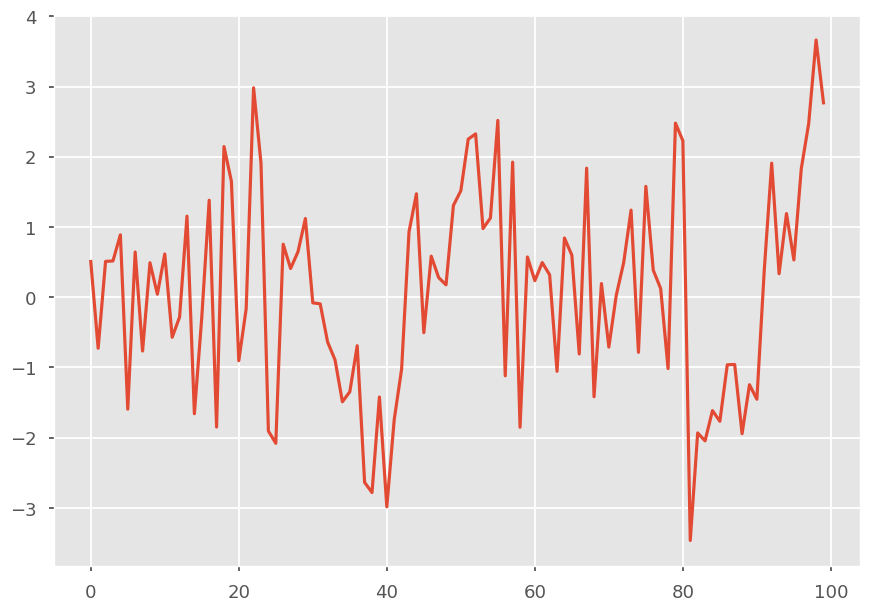

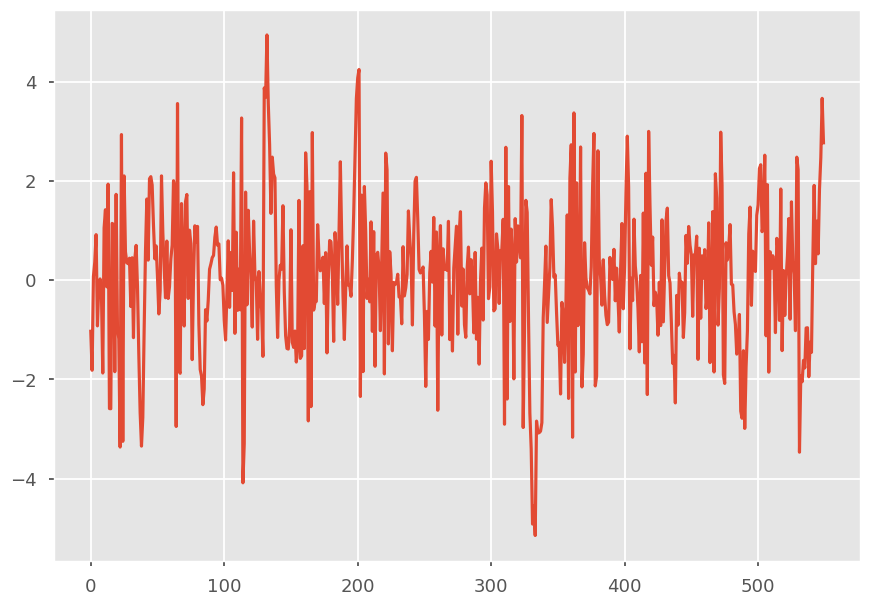

In [104]:
list_data = list(dict_setting_list_data.values())[0]

X, Y, exog, oracle_L, oracle_nohidden_L, h_label_L, h_prob_L = list_data[0]
plt.plot(Y[-100:])
plt.savefig(r"plots/prs_edm_sim_data_test.png", dpi = 300)
plt.show()
plt.plot(Y)
plt.savefig(r"plots/prs_edm_sim_data_all.png", dpi = 300)
plt.show()

### Make plot

#### illustrative plot

In [118]:
class DataGenerator:
    
    def __init__(self, n_state = None, trans_type = "given", given_trans_mat = None, timestamp = 10001, start_prob = None,
                 list_mean = 1., list_std = 1., clu_dist = "Gaussian", clu_dist_kargs = {}, dim_space = 10, random_state = 434):
        
        if trans_type == "given":
            trans_mat = np.array(given_trans_mat)
            n_state = len(trans_mat)
        else:
            
            dict_transtype_diag = {"very_sticky": 0.96, "moderate_sticky": 0.9, "non_sticky": 0.6,
                                   "sticky_08": 0.8, "sticky_07": 0.7, "sticky_06": 0.6, "sticky_05": 0.5, "sticky_04": 0.4, }
            
            trans_mat = []
            for ii in range(n_state):
                tmp_line = []
                for jj in range(n_state):
                    tmp_prob = dict_transtype_diag[trans_type] if ii == jj else ((1 - dict_transtype_diag[trans_type]) / (n_state - 1))
                    tmp_line.append(tmp_prob)
                trans_mat.append(tmp_line)
            trans_mat = np.array(trans_mat)
            
        self.trans_mat = trans_mat
        self.n_state = n_state
        
        if start_prob is None:
            self.start_prob = np.array([1 / n_state for i in range(n_state)])
        else:
            self.start_prob = np.array(start_prob)
            
        self.dim_space = dim_space
        
        if type(list_std) is float:
            list_std = [list_std for i in range(n_state)]
        self.list_std = np.array([[list_std[i] for j in range(dim_space)] for i in range(n_state)])
        
        if list_mean is None:
            list_mean = 1.
        if type(list_mean) is float:
            list_mean = [list_mean for i in range(n_state)]
        self.list_mean = np.array([[list_mean[i] if i == j else 0. for j in range(dim_space)] for i in range(n_state)])
        
        self.timestamp = timestamp
        self.clu_dist = clu_dist
        self.clu_dist_kargs = clu_dist_kargs
        
        self.random_state = random_state
        
        return
    

    def generate(self, is_return_posterior = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        np.random.seed(self.random_state)
        self.random_state += 1
    
        h_label_L, h_prob_L, obs_L = [], [], []
        h_prob_posterior_L = []
        h0_label = np.random.multinomial(1, self.start_prob)
        prob_h_log_posterior_tmp = np.log(self.start_prob)
        h_label_prev = h0_label
        for index in range(self.timestamp):
            prob_h_tmp = h_label_prev @ self.trans_mat
            h_label_tmp_vec = np.random.multinomial(1, prob_h_tmp)
            h_label_tmp = np.argmax(h_label_tmp_vec)
            
            mean_tmp = self.list_mean[h_label_tmp]
            std_tmp = self.list_std[h_label_tmp]
            
            if self.clu_dist in ["Gaussian", "Normal", "Norm", "N"]:
                X_tmp = np.random.normal(size = len(mean_tmp))
            elif self.clu_dist in ["T", "t", "t-dist", "t-distribution"]:
                X_tmp = np.random.standard_t(size = len(mean_tmp), ** self.clu_dist_kargs)
                
            X_tmp = (X_tmp * std_tmp) + mean_tmp
            
            vec_log_emission_tmp = []
            for ii in range(self.n_state):
                resid_normalized = (X_tmp - self.list_mean[ii]) / self.list_std[ii]
                if self.clu_dist in ["Gaussian", "Normal", "Norm", "N"]:
                    tmp_log_emission = np.sum(scipy.stats.norm.logpdf(resid_normalized, scale = 1.))
                elif self.clu_dist in ["T", "t", "t-dist", "t-distribution"]:
                    tmp_log_emission = np.sum(scipy.stats.t.logpdf(resid_normalized, ** self.clu_dist_kargs))
                vec_log_emission_tmp.append(tmp_log_emission)
            prob_h_log_posterior_tmp = matmul_log(np.transpose(self.trans_mat), prob_h_log_posterior_tmp) + np.array(vec_log_emission_tmp)
            prob_h_log_posterior_tmp -= logsumexp(prob_h_log_posterior_tmp)
            prob_h_posterior_tmp = np.exp(prob_h_log_posterior_tmp)            
            h_prob_posterior_L.append(prob_h_posterior_tmp)
            
            h_label_L.append(h_label_tmp)
            h_prob_L.append(prob_h_tmp)
            obs_L.append(X_tmp)
            h_label_prev = h_label_tmp_vec
            
        if is_return_posterior:
            return h_label_L, h_prob_L, obs_L, h_prob_posterior_L
        else:
            return h_label_L, h_prob_L, obs_L
        
    
# def data_generator(timestamp=10001, start_prob=np.array([1/3, 1/3, 1/3]),
#                    trans_mat=np.array([[0.6, 0.2, 0.2], [0.2, 0.6, 0.2], [0.2, 0.2, 0.6]]), #  less sticky
#                    #trans_mat=np.array([[0.98, 0.01, 0.01], [0.03, 0.95, 0.02], [0.02, 0.01, 0.97]]) #  sticky
#                    sigma2 = 1., p = 0, random_state = 434, ):
    
#     np.random.seed(random_state)
    
#     h_label_L, h_prob_L, obs_L = [], [], []
#     h0_label = np.random.multinomial(1, start_prob)
#     h_label_prev = h0_label
#     for index in range(timestamp):
#         prob_h_tmp = h_label_prev @ trans_mat
#         h_label_tmp_vec = np.random.multinomial(1, prob_h_tmp)
#         h_label_tmp = np.argmax(h_label_tmp_vec)
#         mean_tmp = h_label_tmp_vec
#         if len(mean_tmp) < p:
#             mean_tmp = np.concatenate([mean_tmp, [0 for i in range(p - len(mean_tmp))]])
#         var_tmp = sigma2
#         X_tmp = np.random.normal(mean_tmp, var_tmp)
#         h_label_L.append(h_label_tmp)
#         h_prob_L.append(prob_h_tmp)
#         obs_L.append(X_tmp)
#         h_label_prev = h_label_tmp_vec

#     return h_label_L, h_prob_L, obs_L


In [151]:
tmp_data_generator = DataGenerator(n_state = 2, trans_type = "very_sticky", timestamp = 100, list_std = 0.01, dim_space = 1, random_state = 434)
h_label_L, h_prob_L, obs_L, h_prob_posterior_L = tmp_data_generator.generate(is_return_posterior=True)
Xt = np.array(obs_L).flatten()

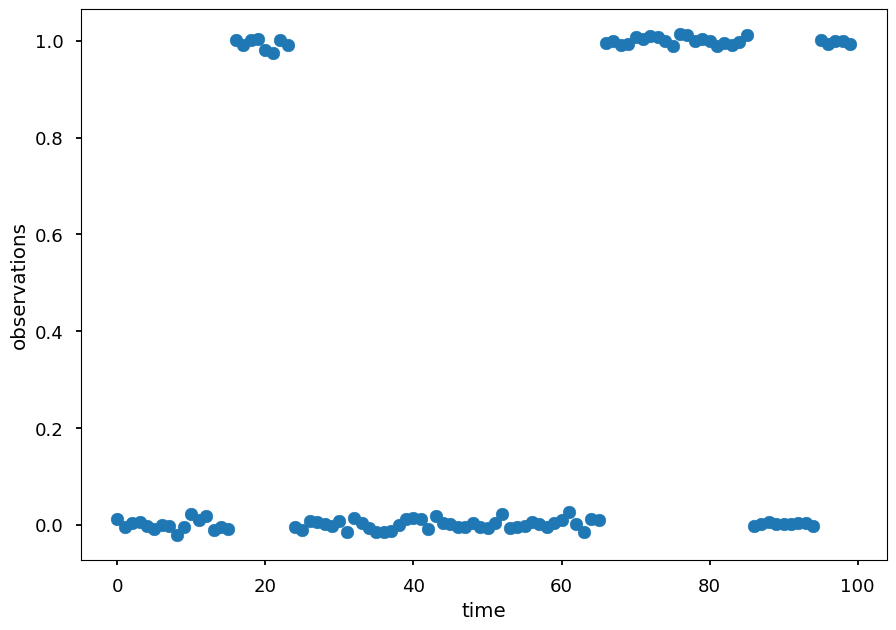

In [154]:
plt.scatter(np.array(range(len(Xt))), Xt)
plt.xlabel("time")
plt.ylabel("observations")
plt.savefig(r"plots/illustrative_hmm_roughRS.png")
plt.show()

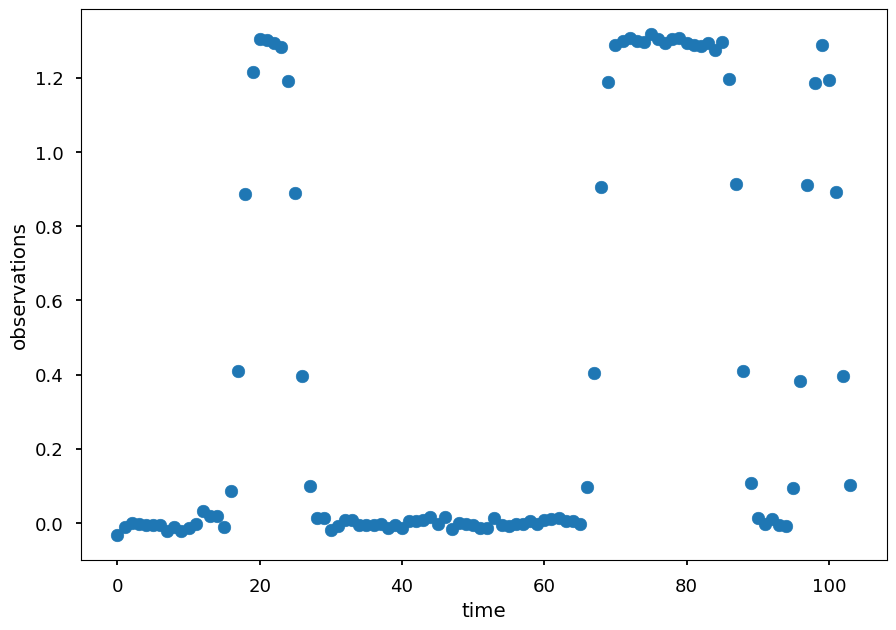

In [155]:
Xt_smooth = np.convolve(Xt, [0.1, 0.3, 0.5, 0.3, 0.1]) 
Xt_smooth += np.random.normal(size = len(Xt_smooth)) * 0.01
plt.scatter(np.array(range(len(Xt_smooth))), Xt_smooth)
plt.xlabel("time")
plt.ylabel("observations")
plt.savefig(r"plots/illustrative_hmm_smoothRS.png")
plt.show()

## End of NB